<a href="https://colab.research.google.com/github/gabilodeau/INF6804/blob/master/Zero_Shot_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### INF8225 - Intelligence artificielle : techniques probabilistes et d’apprentissage

**Polytechnique Montréal**  
**Auteurs :** Xavier Chalifoux et Guillaume Prégent

**Description :** Ce notebook présente BLA BLA BLA


#### 1. Imports

In [ ]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os
import wandb

In [7]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    labels_list = []  # Store labels separately
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                data.append(resized_arr)  # Append only the image data
                labels_list.append(class_num)  # Append the corresponding label
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    
    return np.array(data), np.array(labels_list)

In [11]:
# Ca prends quelques minutes...
print("Fetching Training data...")
x_train, y_train = get_training_data('chest_xray/chest_xray/train')

print("Fetching Testing data...")
x_test, y_test = get_training_data('chest_xray/chest_xray/test')

print("Fetching Validation data...")
x_val, y_val = get_training_data('chest_xray/chest_xray/val')

Fetching Training data...
Fetching Testing data...
Fetching Validation data...
Error loading image .DS_Store: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Error loading image .DS_Store: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [13]:
print("Training data shape:", x_train.shape, y_train.shape)
print("Testing data shape:", x_test.shape, y_test.shape)
print("Validation data shape:", x_val.shape, y_val.shape)

print(y_train)

Training data shape: (5216, 150, 150) (5216,)
Testing data shape: (624, 150, 150) (624,)
Validation data shape: (16, 150, 150) (16,)
[0 0 0 ... 1 1 1]


<Axes: xlabel='count'>

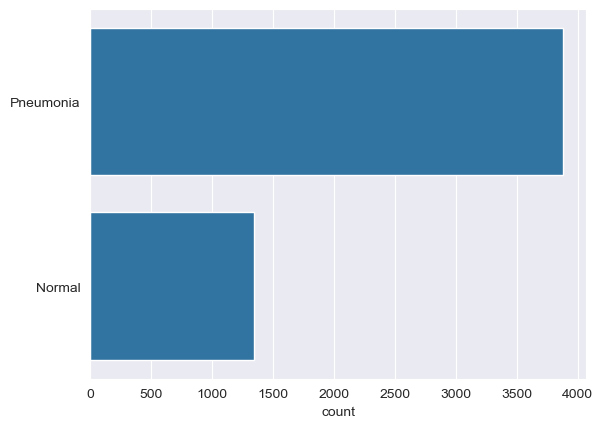

In [14]:
l = []
for i in y_train:
    if(i == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

Data imbalance to handle in training data

<Axes: xlabel='count'>

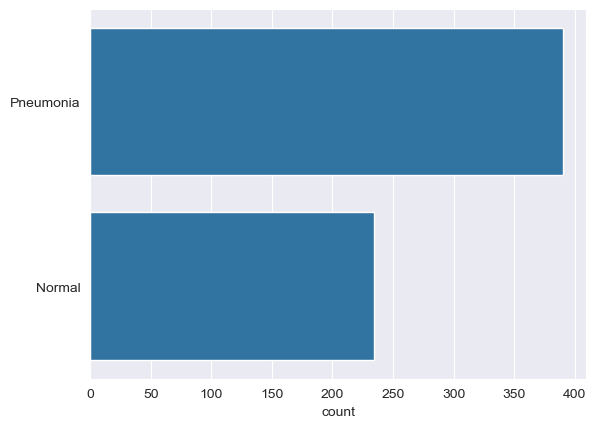

In [16]:
l = []
for i in y_test:
    if(i == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

<Axes: xlabel='count'>

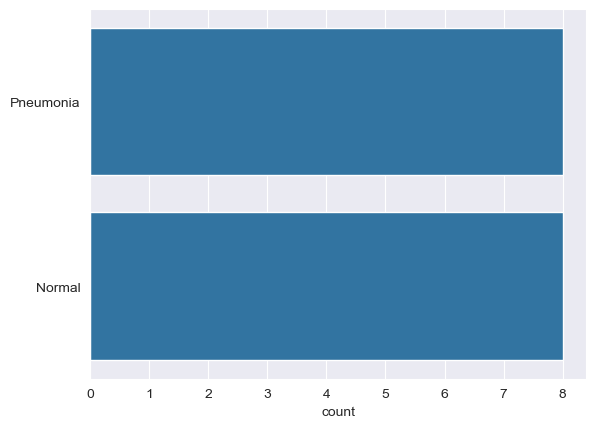

In [17]:
l = []
for i in y_val:
    if(i == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

Text(0.5, 1.0, 'NORMAL')

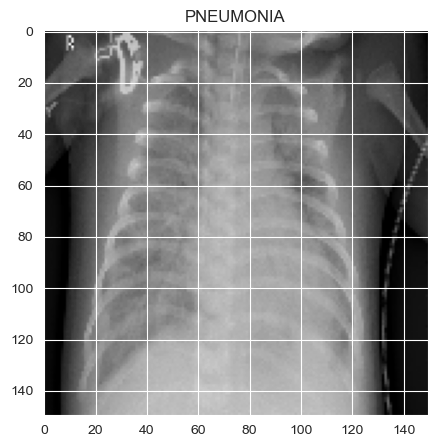

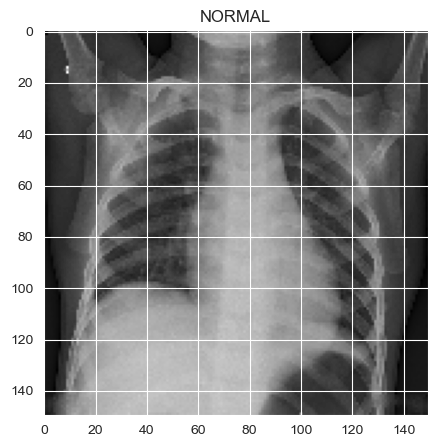

In [20]:
plt.figure(figsize = (5,5))
plt.imshow(x_train[0], cmap='gray')
plt.title(labels[y_train[0]])

plt.figure(figsize = (5,5))
plt.imshow(x_train[-1], cmap='gray')
plt.title(labels[y_train[-1]])

In [21]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [22]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

On pourrait ou non faire du data augmentation pour équilibrer pneumonie ou non

In [ ]:
# Initialize Weights & Biases
wandb.init(project="pneumonia-classification-resnet")

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # Modify final layer for binary classification
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in zip(x_train,y_train):
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(x_train)
    wandb.log({"epoch": epoch, "loss": avg_loss})
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Save model
torch.save(model.state_dict(), "resnet_binary_classification.pth")
wandb.finish()
